<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/master/4_mlflow_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Práctico 1  
## Implementación de una red neuronal simple MLP.

### Módulo optativo de la diplomatura en ciencia de datos del FaMAF - Universidad Nacional de Córdoba. 2022

**Ingerantes del grupo:**
- Alonso, Guillermo 
- Pfluger, Santiago
- Perez, Lucas
- Serrantes, Sebastián

**Profesores:** 
- Johanna Frau 
- Mauricio Mazuecos

### Librerías

In [2]:
import gzip
import mlflow
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange

import json
import bz2

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

## Dataset

Utilizamos el dataset del Meli Challenge 2019. El mismo contiene los datos de publicaciones de ventas en Mercado Libre.

En este caso tomamos los datos en español solamente quedando 6.119.100 registros en total y 632 categorías únicas.

Se descartaron las columnas ya trabajadas y se realizó el tokenizado preprocesado desde 0 utilizando solamente la columna `title` como `data` y `category` como `target`.


In [3]:
class MeliChallenge(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

## Preprocesamiento

En este caso vamos a utilizar un sólo módulo para transformar los datos. Este se encargará de preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings.

Vamos a estar trabajando con la librería [gensim](https://pypi.org/project/gensim/) previamente importada para el procesamiento del lenguaje natural (pueden ver su código open source en este [link](https://github.com/RaRe-Technologies/gensim) ).



In [4]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

## Lectura de datos

### Train

In [5]:
train_dataset = pd.concat([x for x in pd.read_json(f"/users/galonso/data/meli-challenge-2019/spanish.train.jsonl.gz", lines=True, chunksize=100000)], ignore_index=True)
train_dataset = train_dataset[['title', 'category']]
train_dataset.head()

,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES


Como el dataset ya viene separado en **train - validation - test**, armo uno completo `fulldataset` para extraer el diccionario con todas las palabras.

In [11]:
fulldataset=train_dataset.copy()

In [13]:
len(train_dataset)

4895280

### Test

In [14]:
test_dataset = pd.read_json(f"/users/galonso/data/meli-challenge-2019/spanish.test.jsonl.gz", lines=True)

In [15]:
test_dataset = test_dataset[['title', 'category']]
test_dataset.head()

,title,category
0,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...,DIAPER_BAGS
1,Bolso Maternal/bebe Incluye Cambiador + Correa...,DIAPER_BAGS
2,Mochila Maternal Land + Gancho Envio Gratis-cc,DIAPER_BAGS
3,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS
4,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS


In [16]:
len(test_dataset)

63680

In [19]:
fulldataset=fulldataset.append(test_dataset)#ignore_index = True)

## Validation

In [21]:
validation_dataset = pd.read_json(f"/users/galonso/data/meli-challenge-2019/spanish.validation.jsonl.gz", lines=True)

In [22]:
validation_dataset=validation_dataset[['title', 'category']]
validation_dataset.head()

,title,category
0,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS
1,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS
2,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS
3,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES
4,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS


In [23]:
validation_dataset.shape

(1223820, 2)

In [27]:
fulldataset=fulldataset.append(validation_dataset)
fulldataset.shape

/tmp/ipykernel_958642/1784253834.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fulldataset=fulldataset.append(validation_dataset)


(6119100, 2)

In [29]:
preprocess_full = RawDataProcessor(fulldataset)
test_dataset = MeliChallenge(test_dataset, transform=preprocess_full)
train_dataset = MeliChallenge(train_dataset, transform=preprocess_full)
validation_dataset = MeliChallenge(validation_dataset, transform=preprocess_full)

## Collation function

Como en este caso trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un *batch* de datos, el `DataLoader` de PyTorch espera que los datos del *batch* tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija). Esto lo podemos lograr mediante el parámetro de `collate_fn`. En particular, esta función se encarga de tomar varios elementos de un `Dataset` y combinarlos de manera que puedan ser devueltos como un tensor de PyTorch. Se define un módulo `PadSequences` que toma un valor mínimo, opcionalmente un valor máximo y un valor de relleno (*pad*) y dada una lista de secuencias, devuelve un tensor con *padding* sobre dichas secuencias.

In [30]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

## DataLoaders

Ya habiendo definido nuestros conjuntos de datos y nuestra `collation_fn`, podemos definir nuestros `DataLoader`, uno para entrenamiento y otro para evaluación. Ver que la diferencia fundamental está en `shuffle`, no queremos mezclar los valores de evaluación cada vez que evaluamos porque al evaluar mediante *mini-batchs* nos puede generar inconsistencias.

In [31]:
pad_sequences = PadSequences()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)


## El modelo de clasificación

Para clasificación utilizaremos un perceptrón multicapa de dos capas ocultas. En particular, tenemos la capa de `Embeddings` que es rellenada con los valores de embeddings preentrenados.

In [33]:
# Archivo de Embeddings
#!curl -L https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -O

In [34]:
class MeliClassifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.hidden1 = nn.Linear(vector_size, hidenlayer1)
        self.hidden2 = nn.Linear(hidenlayer1, hidenlayer2)
        self.output = nn.Linear(hidenlayer2, 632)              #632 clases de salida.
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)  # Output Layer
        #x = F.softmax(x, dim=1)
        return x

## Experimento de MLflow

Por último, ya tenemos todos los bloques para construir nuestro experimento de MLflow. Anotamos los parámetros del modelo y lanzamos a correr nuestro experimento. Cada vez que finaliza un epoch guardamos algunas métricas. Al finalizar todos los epochs corremos algunas métricas extras de evaluación.

In [35]:
torch.cuda.is_available()

True

In [36]:
mlflow.set_experiment("a_NaiveMeliChallenge_experiment_Final")
EPOCHS=10
hidenlayer1=2048
hidenlayer2=2048
learningRate=0.005
with mlflow.start_run():
    mlflow.log_param("model_name", "mlp6_fullCat")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden1_size": hidenlayer1,
        "hidden2_size": hidenlayer2,
        "Epochs": EPOCHS,
        "optimizer": "optim.SGD_lr_momentum=0.9",
        "Learning Rate": learningRate
    })
    model = MeliClassifier("./SBW-vectors-300-min5.txt.bz2", preprocess_full.dictionary, 300, True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)
    for epoch in trange(EPOCHS):
        model.train()
        running_loss = []
        targets = []
        predictions = []
        #Train
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            output = model(batch["data"].cuda())
            loss_value = loss(output, batch["target"].cuda().squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("train_bas", balanced_accuracy_score(targets, predictions), epoch)
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        # Validation
        for batch in tqdm(validation_loader):
            output = model(batch["data"].cuda())
            running_loss.append(
                loss(output, batch["target"].cuda().squeeze().long()).item() 
            )
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
        mlflow.log_metric("validation_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("validation_bas", balanced_accuracy_score(targets, predictions), epoch)
        
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs, labels = data
            outputs = model(data['data'].cuda())
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(data['target'].numpy())
            y_pred.extend(predicted.cpu().numpy())
        mlflow.log_metric("test_bas", balanced_accuracy_score(y_true, y_pred), epoch)
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

  0%|          | 0/9562 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

'with tempfile.TemporaryDirectory() as tmpdirname:\n        targets = []\n        predictions = []\n        for batch in tqdm(test_loader):\n            output = model(batch["data"].cuda())\n            targets.extend(batch["target"].cpu().numpy())\n            predictions.extend(output.cpu().squeeze().detach().numpy())\n        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(\n            f"{tmpdirname}/predictions.csv.gz", index=False\n        )\n        mlflow.log_metric("test_bas", balanced_accuracy_score(targets, predictions), epoch)\n        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")'

## Classification report y matriz de confusión sobre los datos de test.

In [45]:
y_true = []
y_pred = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        outputs = model(data['data'].cuda())
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(data['target'].numpy())
        y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
print('------------TEST------------')
print('Balanced Accuracy score Test: ', balanced_accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(cm)

  0%|          | 0/498 [00:00<?, ?it/s]

------------TEST------------
Balanced Accuracy score Test:  0.8424137492135819
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87        98
         1.0       0.96      0.95      0.95       100
         2.0       0.91      0.70      0.79        98
         3.0       0.55      0.77      0.64       102
         4.0       0.92      0.91      0.91        99
         5.0       0.83      0.74      0.78        98
         6.0       1.00      0.95      0.97       100
         7.0       0.89      0.97      0.93       100
         8.0       0.79      0.95      0.86       101
         9.0       0.82      0.97      0.89       104
        10.0       0.82      0.82      0.82        98
        11.0       0.72      0.83      0.77       101
        12.0       0.87      0.74      0.80       102
        13.0       0.92      0.91      0.92       107
        14.0       0.82      0.91      0.86        99
        15.0       0.68      0.89      0.77       100
  

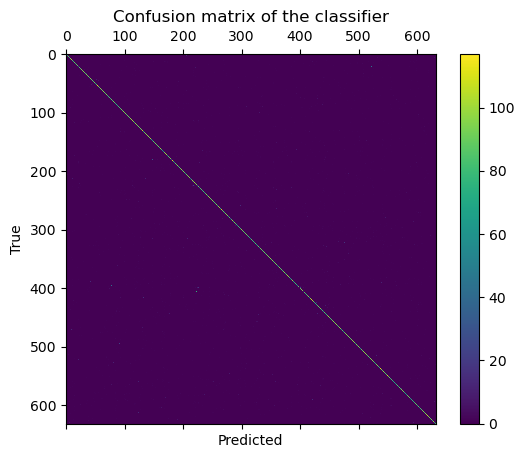

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Guardamos el modelo entranado y los pesos calculados

In [39]:
torch.save(model.state_dict(), 'model_weights.pth')
torch.save(model, 'model.pth')


# Conclusiones:

- El experimento llevó gran esfuerzo y tiempo para lograr ejecutarlo ya que es una gran cantidad de datos y las pruebas de entrenamiento del modelo se hacen bastante extensas en el tiempo. Se trabajó con el modelo y los datos en GPU para el entrenamiento haciendo uso del hardware **nabucodonosor** del Centro de Computación de Alto Desempeño de la UNC. 
- Para las pruebas y construcción del modelo se utilizó una muestra del dataset. Inicialmente de 5 categorias y luego de 20. Para esto se filtraron en todos los datasets (train, validation y test) y se conservaron todos los registros de las categorias seleccionadas reduciendo considerablemente el tamaño y el tiempo de procesamiento.
- Como se puede observar en los registros del experimento se probaron diferentes números de capas ocultas y de diferentes valores, diferentes tipos de capa de salida, distinta cantidad de epochs en el entrenamiento y valores de learning rate. A partir de las pruebas se eligieron los parametros que dieron mejores resultados y luego se entrenó el modelo con el dataset completo. Afortunadamente esto no hizo variar los resultados obtenidos que se mantuvieron aproximadamente en los mismos valores.
    - En relacion al número de capas, en las pruebas no se notó mejora aumentando el número, razon por la cual se mantovo en 2.
    - En relación al valor de las capas, se comenzo con valores bajo y se fue aumentando logrando mejores resultados. Se conservaron los últimos valores que produjeron mejoras en los resultados.
    - En relación al número de epochs y learning rate, con el fin de reducir el tiempo de entrenamiento con el dataset completo, se probó aumentar levemente el lr para lograr llegar con menos epochs a los resultados deseados y se consiguió efectivamente.